# Projeto de Séries Temporais
## Chuvas no município de São Paulo
### João Honorato, Maria Raquel

Estamos usando dados mensais de precipitação de chuva no município de São Paulo, extraídos do Departamento de Águas e Energia Elétrica (DAEE), do período de 1985 a 2022 

link: http://www.hidrologia.daee.sp.gov.br/

A chuva é medida em milímetros, 1 mm de altura de chuva equivale ao volume de 1 litro precipitado sobre uma superfície de 1 m² de área.

As alturas mensais de chuva são as acumuladas entre 7 horas do último dia do mês anterior até às 7 horas do último dia do mês considerado.

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.tsa.stattools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

### Carregando e tratando os dados

In [30]:
# Carregando os dados

chuvasp = pd.read_csv('E3-262_Chuva_Mensal_Serie_20230830_084446.csv', sep=';')
chuvasp.head()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
0,1985,"184,90","242,90","230,00","59,00","126,20","14,60","4,00","21,80","126,10","71,10","111,30","155,20"
1,1986,"199,60","221,00","218,70","106,50","113,10","3,90","30,30",---,"34,50","60,70","242,50","389,90"
2,1987,"525,80",---,"161,30","98,10","293,80","183,90","11,80","30,90","80,20","84,80","72,70","152,10"
3,1988,"268,70","224,40","189,20","175,10","224,90","58,60","1,30","0,20","28,40","173,90","100,20","289,80"
4,1989,"312,90","344,30","288,20","66,30","21,70","52,50","150,10","32,90","52,10","80,10","88,00","236,70"


In [31]:
# Precisamos substituir as vírgulas por pontos para converter os valores para float

chuvasp = chuvasp.replace(',','.', regex=True)
chuvasp.head()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
0,1985,184.90,242.90,230.00,59.00,126.20,14.60,4.00,21.80,126.10,71.10,111.30,155.20
1,1986,199.60,221.00,218.70,106.50,113.10,3.90,30.30,---,34.50,60.70,242.50,389.90
2,1987,525.80,---,161.30,98.10,293.80,183.90,11.80,30.90,80.20,84.80,72.70,152.10
3,1988,268.70,224.40,189.20,175.10,224.90,58.60,1.30,0.20,28.40,173.90,100.20,289.80
4,1989,312.90,344.30,288.20,66.30,21.70,52.50,150.10,32.90,52.10,80.10,88.00,236.70


In [32]:
# De acordo com o DAEE, valores com '---' representam dados inexistentes.
# Vamos substituí-los pela de chuvas de cada mês, dado presente na última linha do dataset

chuvasp.tail()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
34,2019,---,315.50,318.50,172.30,97.30,59.00,195.10,6.70,73.70,75.90,170.80,249.00
35,2020,408.10,363.00,95.50,5.60,13.70,163.80,10.20,62.10,22.90,213.90,162.10,---
36,2021,373.30,174.10,137.80,55.70,38.50,15.50,38.00,44.80,---,152.80,108.20,247.40
37,2022,418.40,136.30,233.60,40.40,67.30,45.90,8.80,35.20,131.30,117.30,197.70,200.40
38,Média:,309.01,249.32,228.13,92.24,84.89,58.09,51.79,28.56,85.08,139.63,145.48,235.36


In [33]:
for coluna, i in zip(chuvasp.columns, range(14)):
    chuvasp[coluna] = chuvasp[coluna].str.replace('---', f'{chuvasp.iloc[-1][i]}')

chuvasp.tail()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
34,2019,309.01,315.50,318.50,172.30,97.30,59.00,195.10,6.70,73.70,75.90,170.80,249.00
35,2020,408.10,363.00,95.50,5.60,13.70,163.80,10.20,62.10,22.90,213.90,162.10,235.36
36,2021,373.30,174.10,137.80,55.70,38.50,15.50,38.00,44.80,85.08,152.80,108.20,247.40
37,2022,418.40,136.30,233.60,40.40,67.30,45.90,8.80,35.20,131.30,117.30,197.70,200.40
38,Média:,309.01,249.32,228.13,92.24,84.89,58.09,51.79,28.56,85.08,139.63,145.48,235.36


In [34]:
valores_medios = chuvasp.iloc[-1][1:].values.astype(float)
valores_medios

array([309.01, 249.32, 228.13,  92.24,  84.89,  58.09,  51.79,  28.56,
        85.08, 139.63, 145.48, 235.36])

In [35]:
# Excluiremos a última linha
chuvasp = chuvasp.drop(chuvasp[chuvasp['Ano'] == '  Média:'].index)

chuvasp.tail()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
33,2018,238.20,84.50,228.13,66.40,25.80,15.00,20.50,28.56,72.90,203.40,134.10,258.00
34,2019,309.01,315.50,318.50,172.30,97.30,59.00,195.10,6.70,73.70,75.90,170.80,249.00
35,2020,408.10,363.00,95.50,5.60,13.70,163.80,10.20,62.10,22.90,213.90,162.10,235.36
36,2021,373.30,174.10,137.80,55.70,38.50,15.50,38.00,44.80,85.08,152.80,108.20,247.40
37,2022,418.40,136.30,233.60,40.40,67.30,45.90,8.80,35.20,131.30,117.30,197.70,200.40


In [36]:
# Excluiremos a coluna ano
chuvasp = chuvasp.drop(columns=['Ano'])

chuvasp.head()

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
0,184.90,242.90,230.00,59.00,126.20,14.60,4.00,21.80,126.10,71.10,111.30,155.20
1,199.60,221.00,218.70,106.50,113.10,3.90,30.30,28.56,34.50,60.70,242.50,389.90
2,525.80,249.32,161.30,98.10,293.80,183.90,11.80,30.90,80.20,84.80,72.70,152.10
3,268.70,224.40,189.20,175.10,224.90,58.60,1.30,0.20,28.40,173.90,100.20,289.80
4,312.90,344.30,288.20,66.30,21.70,52.50,150.10,32.90,52.10,80.10,88.00,236.70


In [37]:
# Convertendo os valores para float

chuvasp = chuvasp.astype(float)

In [38]:
valores = list(chuvasp.values.flatten())
print(valores)

[184.9, 242.9, 230.0, 59.0, 126.2, 14.6, 4.0, 21.8, 126.1, 71.1, 111.3, 155.2, 199.6, 221.0, 218.7, 106.5, 113.1, 3.9, 30.3, 28.56, 34.5, 60.7, 242.5, 389.9, 525.8, 249.32, 161.3, 98.1, 293.8, 183.9, 11.8, 30.9, 80.2, 84.8, 72.7, 152.1, 268.7, 224.4, 189.2, 175.1, 224.9, 58.6, 1.3, 0.2, 28.4, 173.9, 100.2, 289.8, 312.9, 344.3, 288.2, 66.3, 21.7, 52.5, 150.1, 32.9, 52.1, 80.1, 88.0, 236.7, 284.1, 196.9, 310.1, 85.8, 77.9, 50.6, 121.2, 76.3, 97.2, 206.8, 116.3, 149.8, 330.7, 340.3, 522.4, 200.3, 43.3, 96.8, 28.2, 37.3, 101.4, 168.0, 67.3, 237.9, 129.2, 258.5, 228.13, 87.2, 93.5, 11.6, 40.9, 24.7, 150.6, 219.6, 145.48, 211.7, 221.5, 225.7, 110.0, 84.6, 133.9, 74.7, 11.2, 40.8, 210.1, 134.1, 125.5, 170.5, 196.9, 184.4, 231.6, 111.4, 54.9, 30.5, 39.2, 2.4, 1.8, 147.6, 86.6, 276.3, 373.8, 383.1, 267.7, 73.9, 79.7, 31.2, 46.8, 1.5, 44.2, 202.6, 115.1, 235.36, 334.3, 376.5, 284.5, 42.3, 21.7, 45.1, 12.2, 41.2, 179.4, 179.8, 87.4, 243.9, 235.0, 187.6, 57.1, 63.2, 88.2, 124.7, 12.5, 28.8, 118.0,

In [39]:
anos = pd.date_range('1985', periods = len(valores), freq = 'M')
anos

DatetimeIndex(['1985-01-31', '1985-02-28', '1985-03-31', '1985-04-30',
               '1985-05-31', '1985-06-30', '1985-07-31', '1985-08-31',
               '1985-09-30', '1985-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', length=456, freq='M')

In [40]:
serie = pd.Series(valores, index = anos)
serie

1985-01-31    184.9
1985-02-28    242.9
1985-03-31    230.0
1985-04-30     59.0
1985-05-31    126.2
              ...  
2022-08-31     35.2
2022-09-30    131.3
2022-10-31    117.3
2022-11-30    197.7
2022-12-31    200.4
Freq: M, Length: 456, dtype: float64

In [41]:
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov','Dez']
serie_medias = pd.Series(valores_medios, index = meses)
serie_medias

Jan    309.01
Fev    249.32
Mar    228.13
Abr     92.24
Mai     84.89
Jun     58.09
Jul     51.79
Ago     28.56
Set     85.08
Out    139.63
Nov    145.48
Dez    235.36
dtype: float64

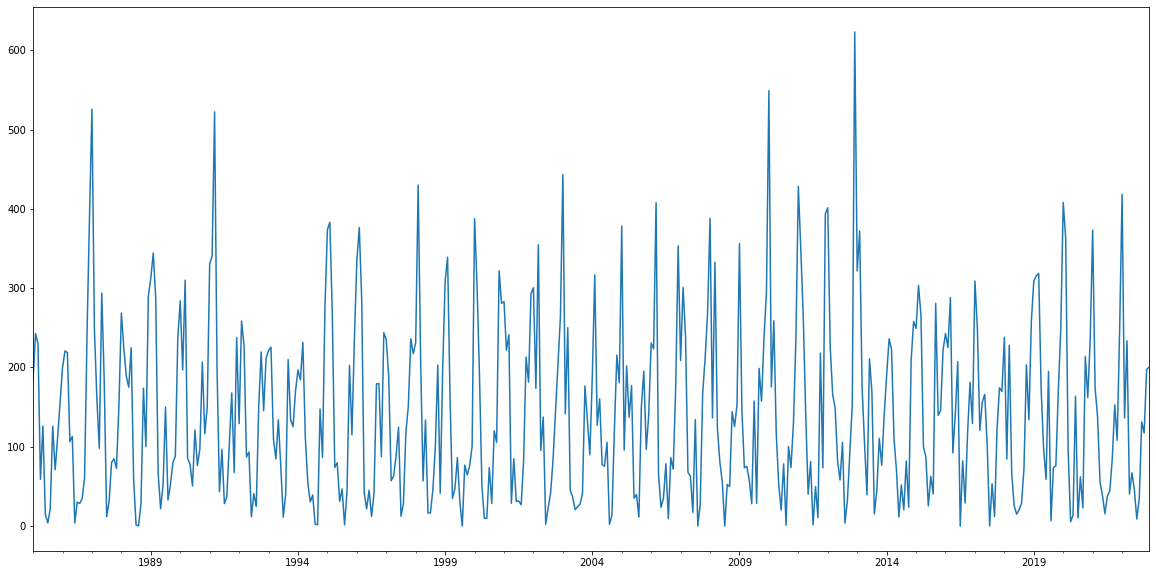

In [42]:
plt.rcParams['figure.figsize'] = (20, 10)
serie.plot();

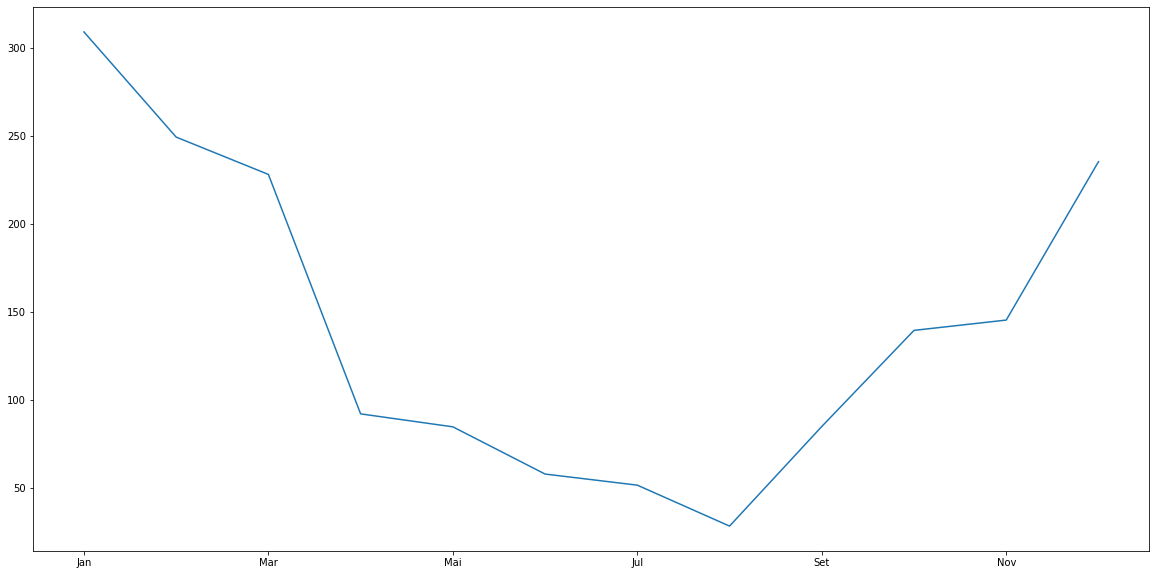

In [43]:
serie_medias.plot();

### Média móvel

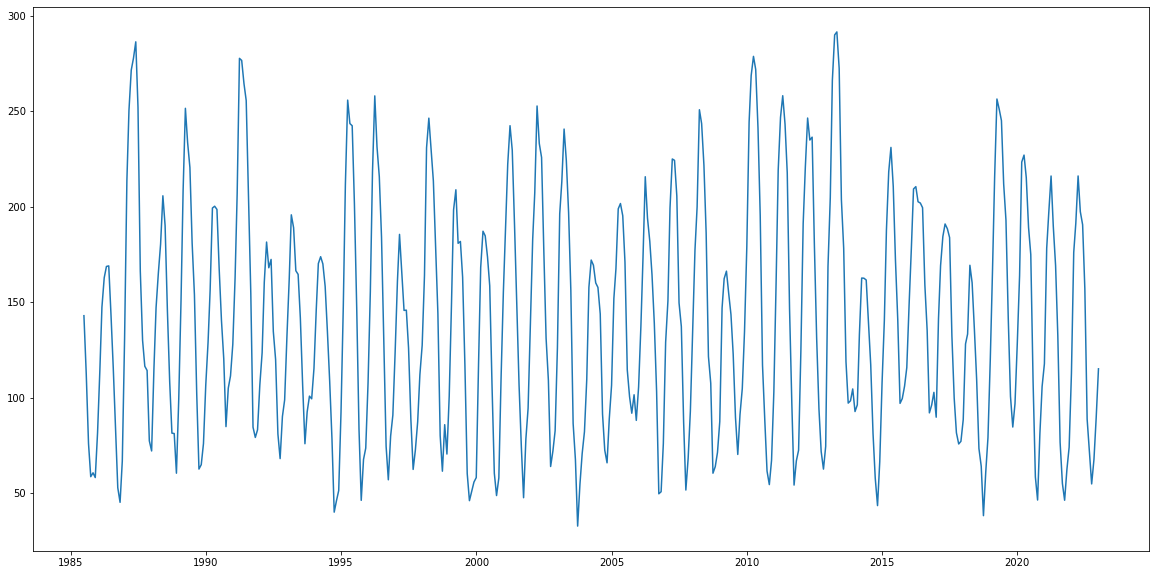

In [44]:
media_movel = serie.rolling(window = 6)
media_movel = media_movel.mean()
plt.plot(media_movel);

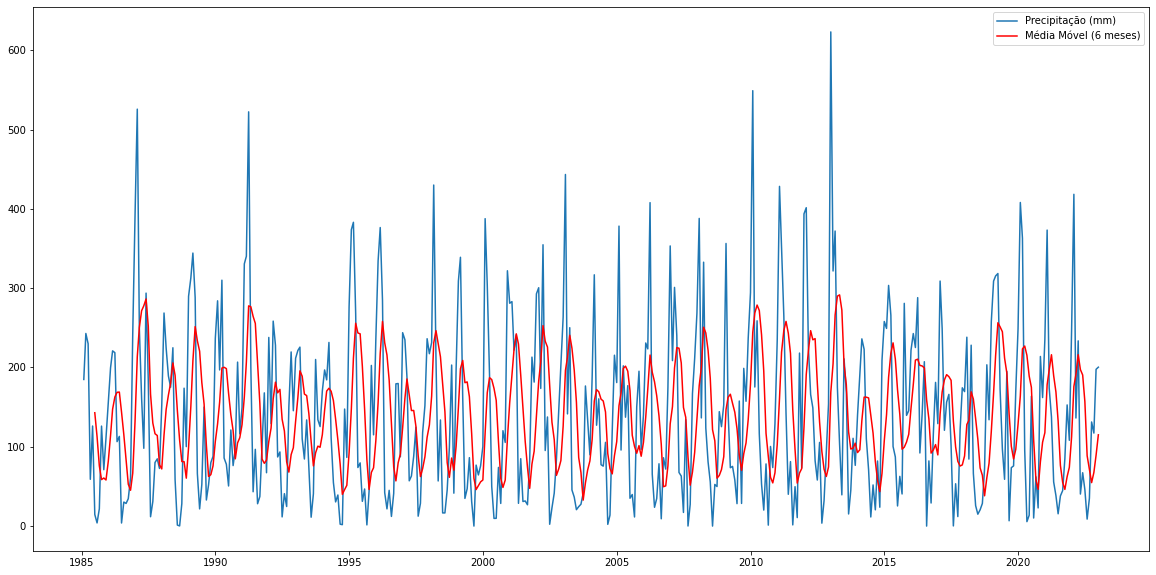

In [45]:
plt.plot(serie, label = 'Precipitação (mm)')
plt.plot(media_movel,color='red', label='Média Móvel (6 meses)')
plt.legend(loc='best')
plt.show()

### Decomposição

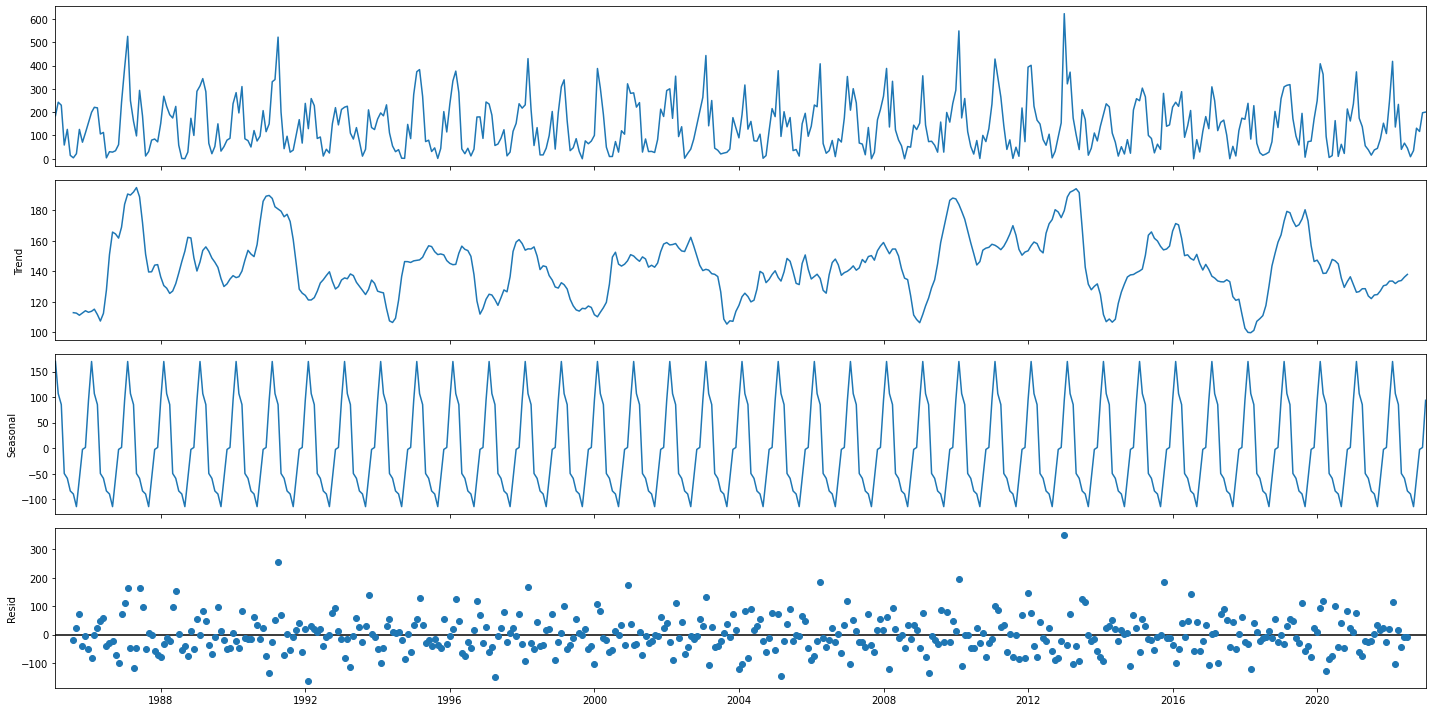

In [46]:
decomposicao = seasonal_decompose(serie)
decomposicao.plot();

### Normalidade

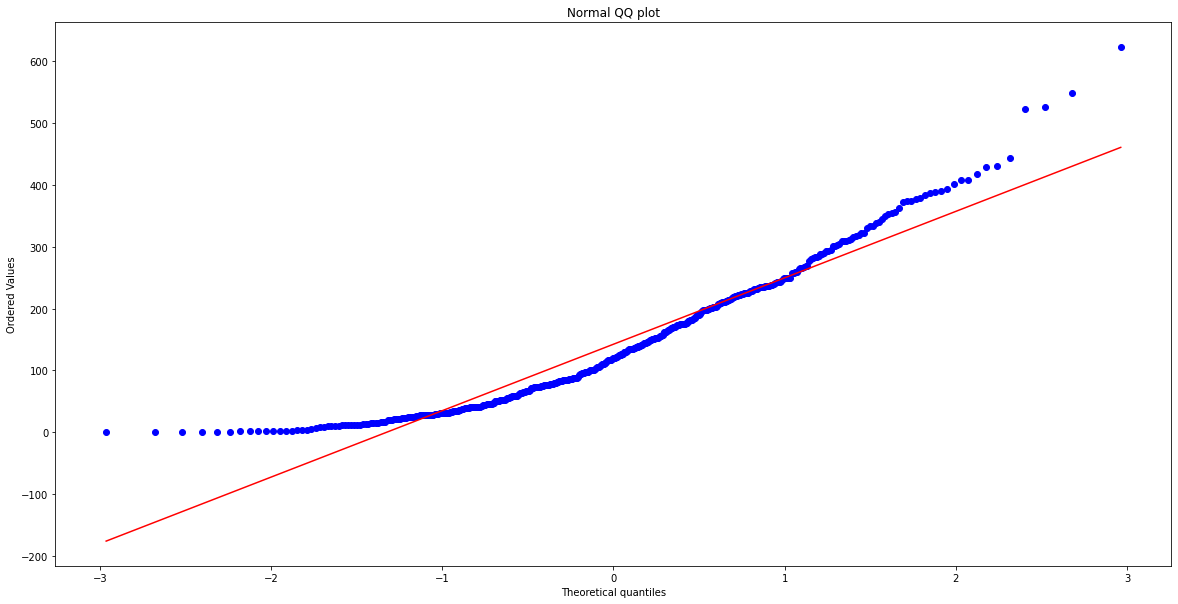

In [47]:
stats.probplot(serie, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

Ho = distribuição normal p > 0,05

Ha = distribuição não normal p <= 0,05

In [48]:
e, p = stats.shapiro(serie)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9242781400680542
p-valor: 2.1459018982876617e-14


Transformação por log (Diminuir variância e melhorar normalidade)

In [49]:
serie_log = np.log(serie)
e, p = stats.shapiro(serie_log)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: nan
p-valor: 1.0


/home/raquel/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Transformação por raiz cúbica (quando possui dados com valor zero ou negativos)

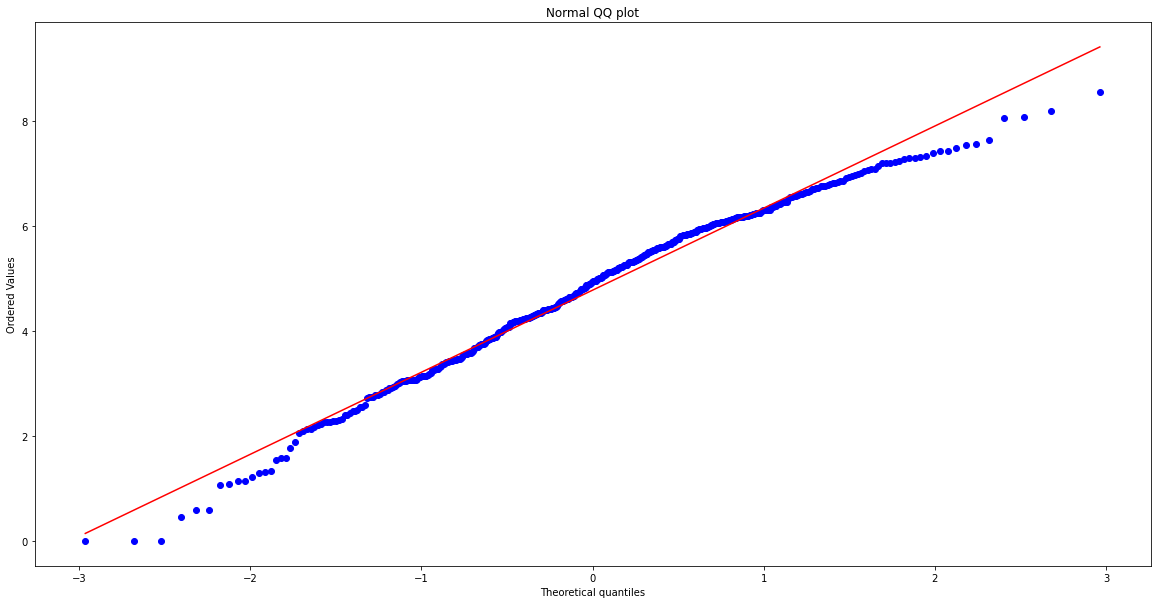

In [50]:
serie_cube = (serie)**(1/3)
stats.probplot(serie_cube, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

In [51]:
e, p = stats.shapiro(serie_cube)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9843399524688721
p-valor: 7.864878716645762e-05


/home/raquel/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


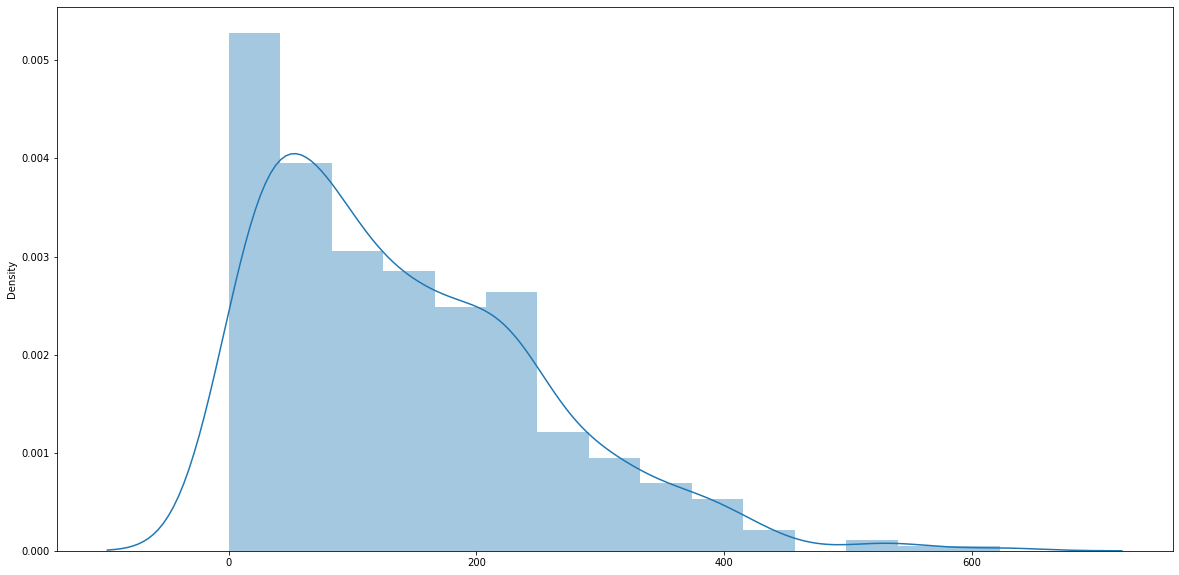

In [52]:
sns.distplot(serie);

/home/raquel/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


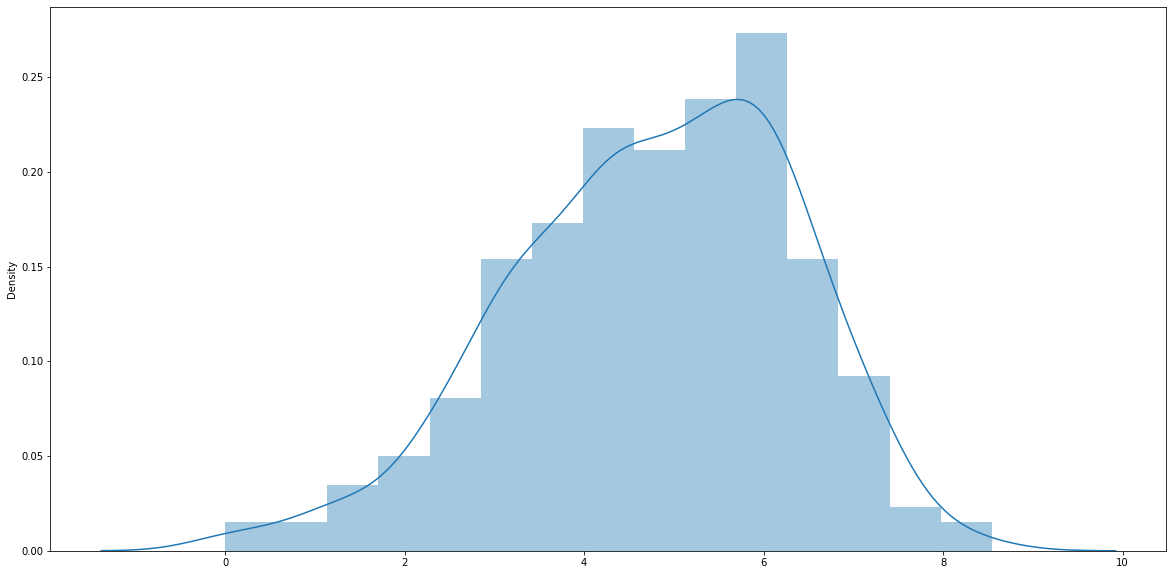

In [53]:
sns.distplot(serie_cube);

### Estacionaridade

Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)

Ho = não é estacionário: estatística do teste > valor crítico

Ha = é estacionário:  estatística do teste < valor crítico

In [54]:
kpss = statsmodels.tsa.stattools.kpss(serie_cube)
print('Estatítica do teste: {:.4f}'.format(kpss[0]))
print('p_valor: {:.4f}'.format(kpss[1]))
print('Valores Críticos:')
for chave, valor in kpss[3].items():
    print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: 0.0166
p_valor: 0.1000
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


/tmp/ipykernel_7212/2379016670.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss = statsmodels.tsa.stattools.kpss(serie_cube)


### Autocorrelação

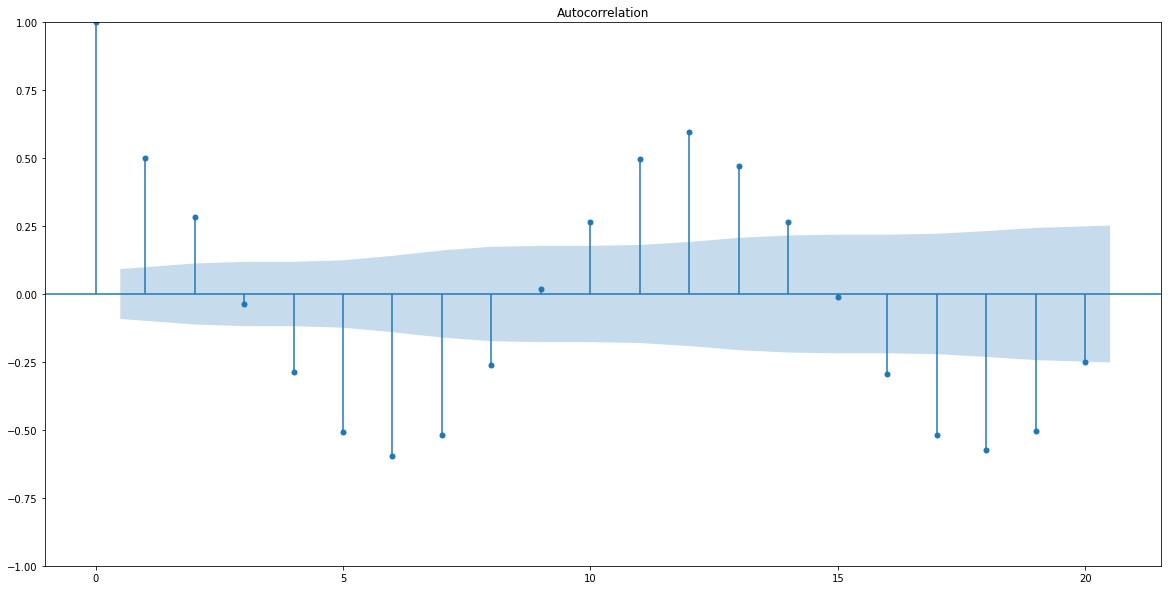

In [55]:
plot_acf(serie_cube, lags=20)
plt.show()

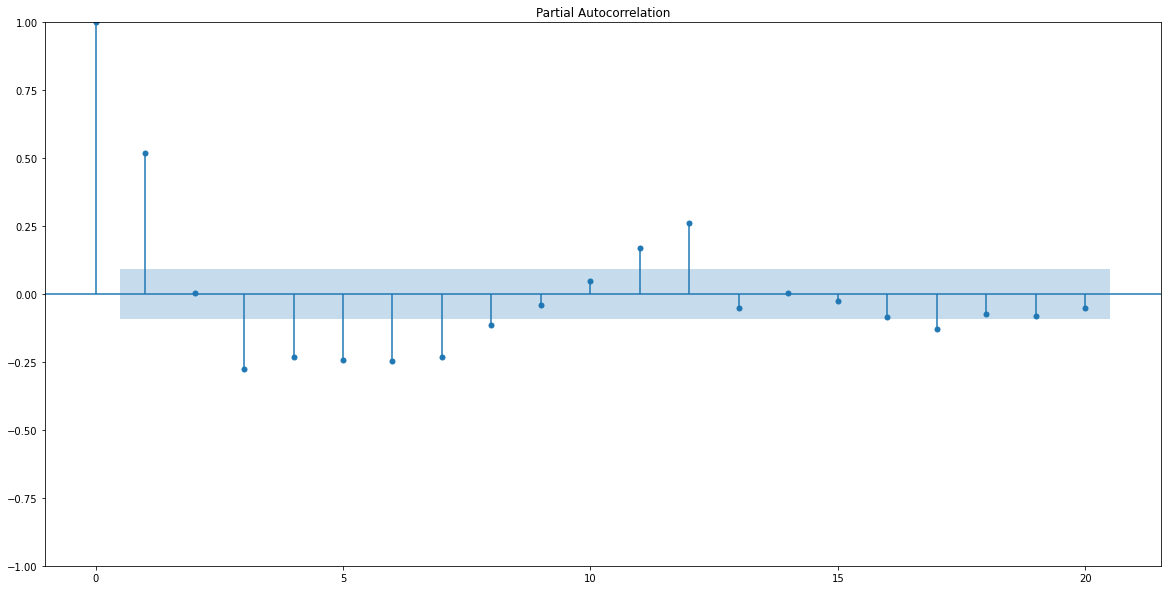

In [56]:
plot_pacf(serie, lags=20)
plt.show()

A série é autocorrelacionada, mas não tem problema, pois esse é um pressuposto da análise dos resíduos dos modelos de séries temporais.

## Modelo AR

In [58]:
modelo_ar = ARIMA(serie_cube, order = (9,0,0))
resultado = modelo_ar.fit()
print(resultado.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:                 ARIMA(9, 0, 0)   Log Likelihood                -689.039
Date:                Tue, 05 Sep 2023   AIC                           1400.077
Time:                        16:55:56   BIC                           1445.424
Sample:                    01-31-1985   HQIC                          1417.940
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7754      0.034    142.470      0.000       4.710       4.841
ar.L1          0.1366      0.044      3.134      0.002       0.051       0.222
ar.L2          0.0710      0.052      1.372      0.1

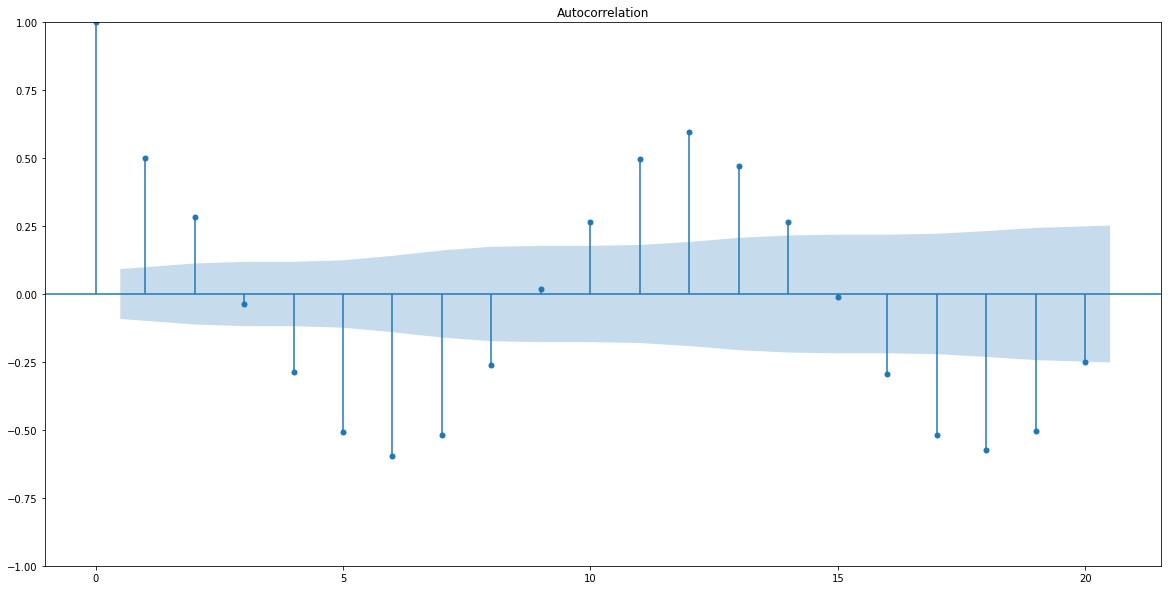

In [60]:
plot_acf(serie_cube, lags=20)
plt.show()

Melhor AIC: 1337.922 = (9,0,0)

### Análise dos Resíduos

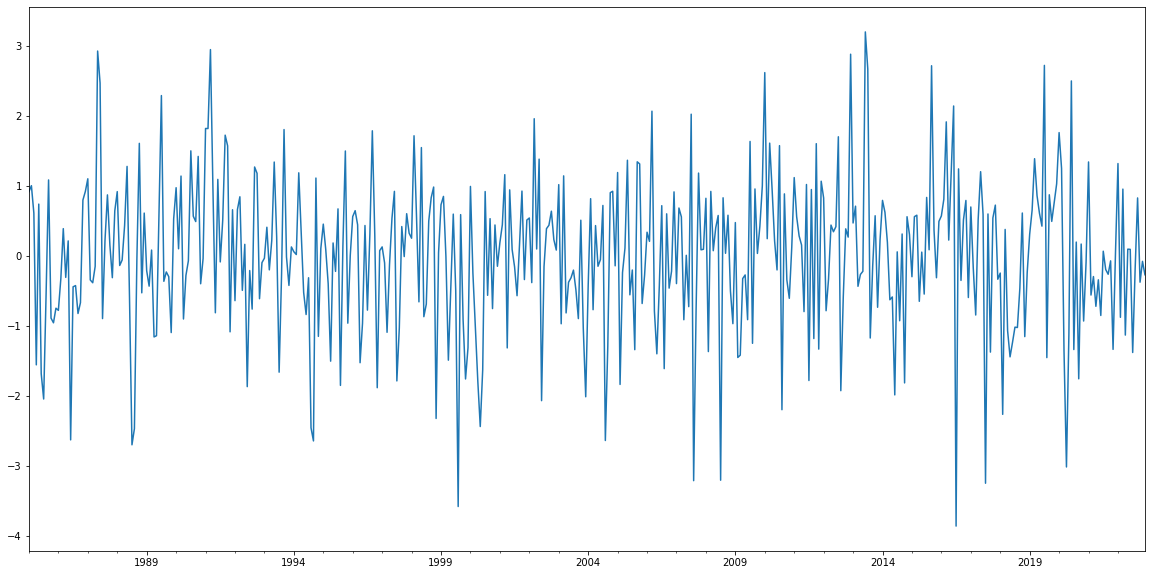

In [62]:
residuos = resultado.resid
residuos.plot();

Normalidade

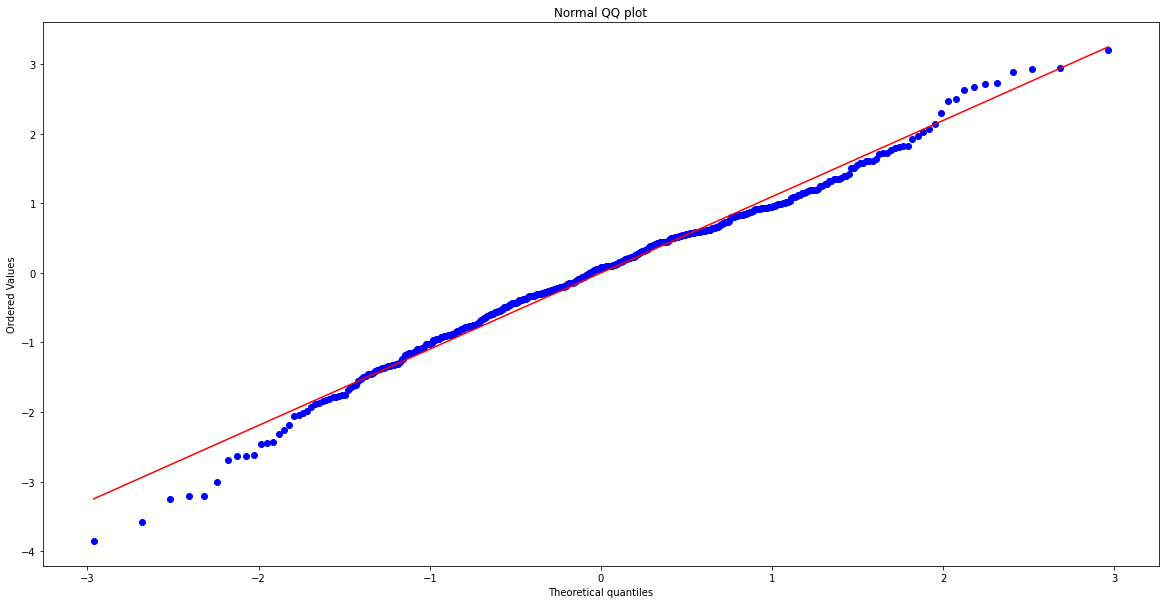

In [63]:
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

In [66]:
e, p = stats.shapiro(residuos)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9884586930274963
p-valor: 0.0011491571785882115


/home/raquel/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


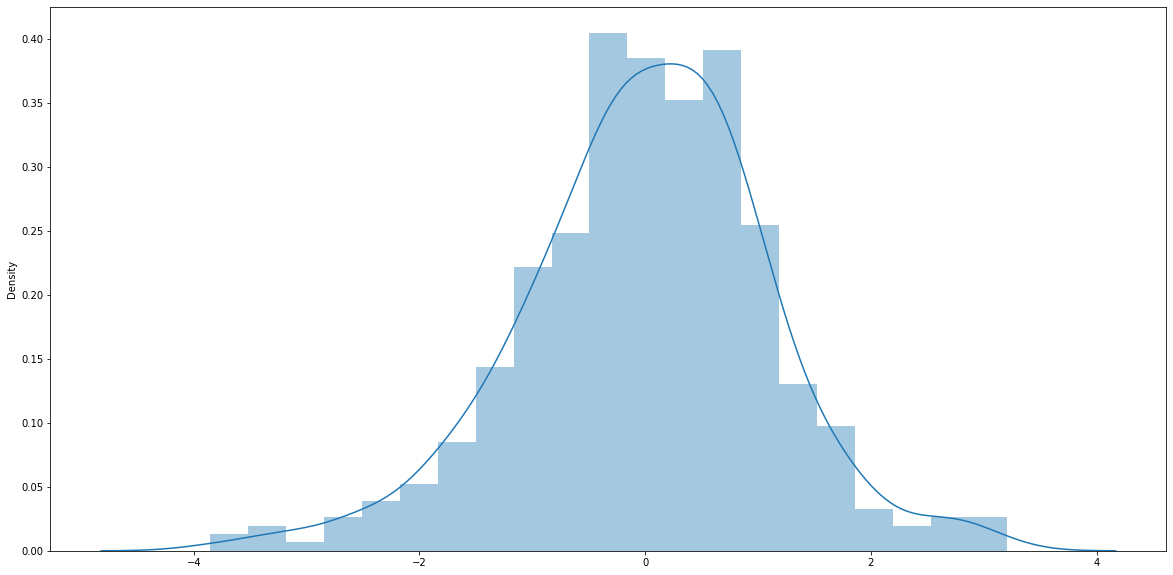

In [67]:
sns.distplot(residuos);

Autocorrelação

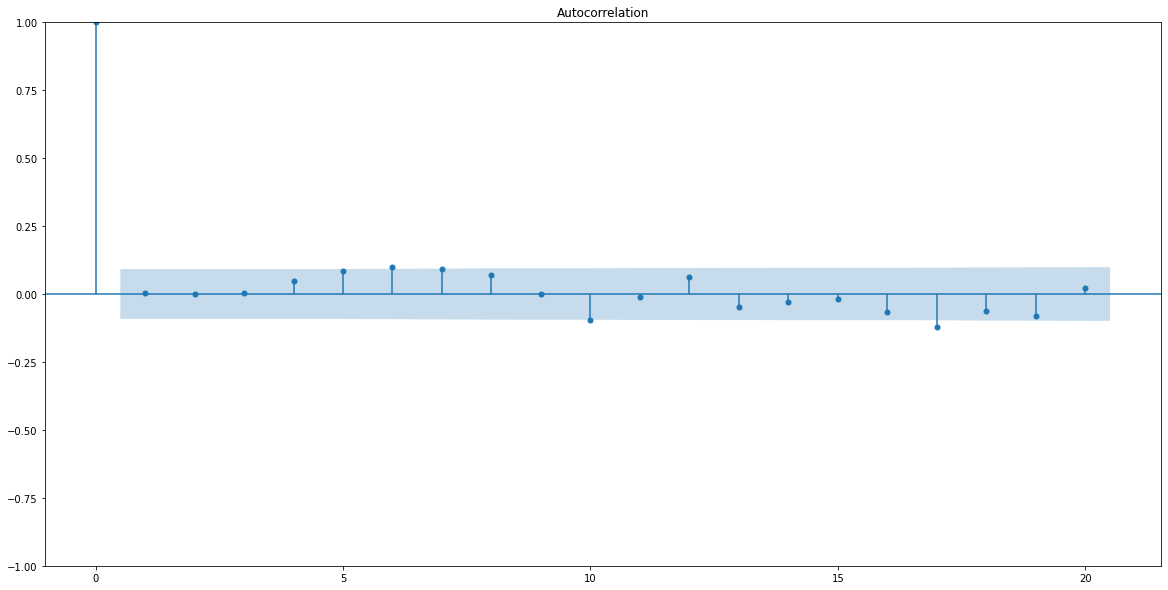

In [68]:
plot_acf(residuos, lags=20)
plt.show()

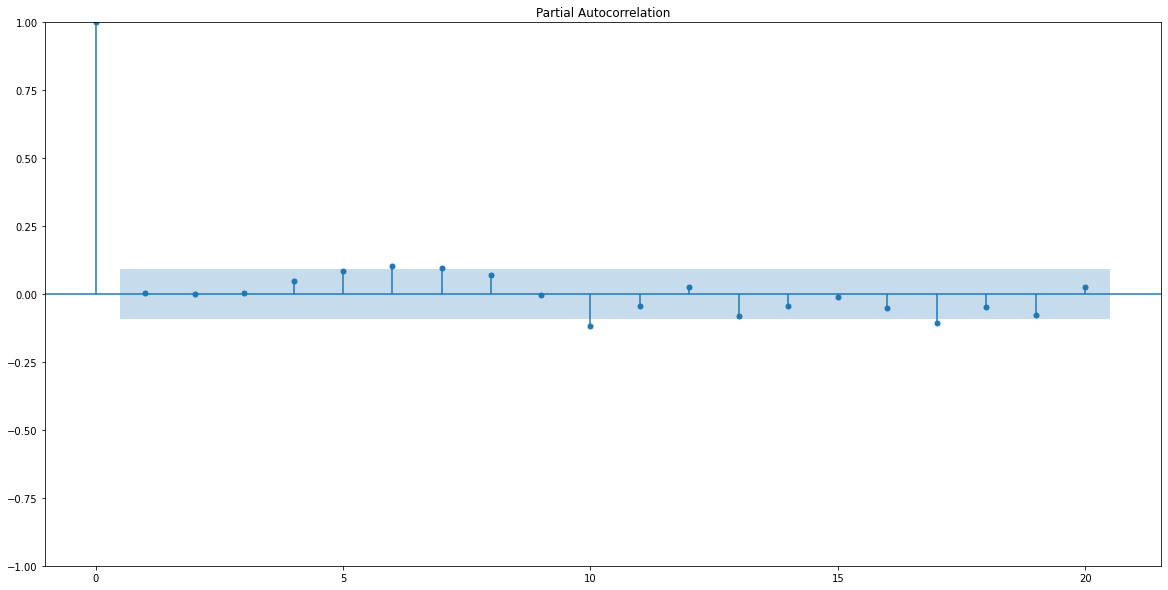

In [69]:
plot_pacf(residuos, lags=20)
plt.show()

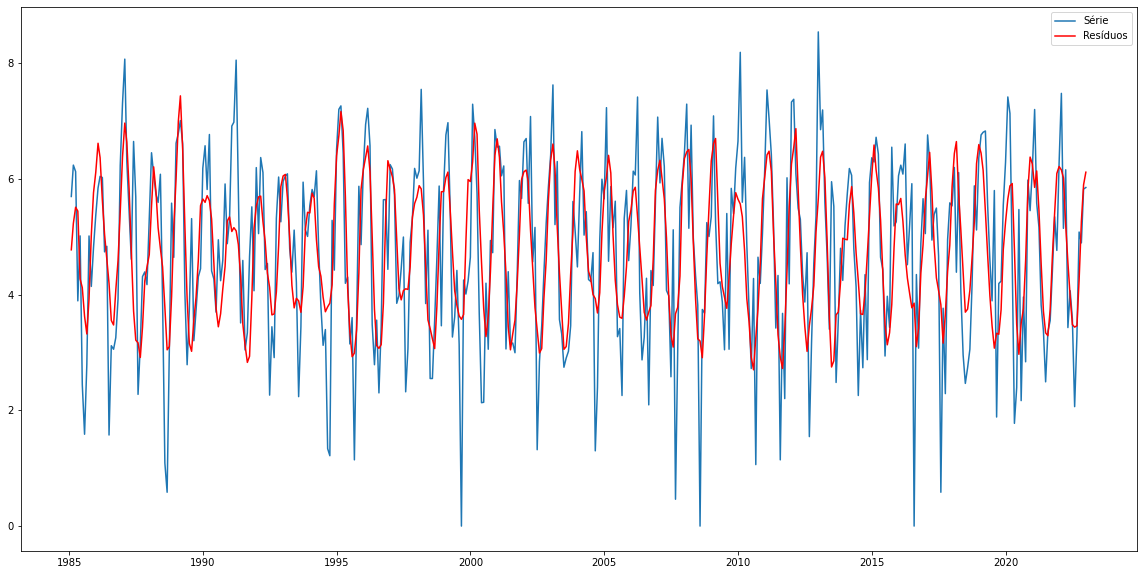

In [71]:
plt.plot(serie_cube, label='Série')
plt.plot(serie_cube-residuos,color='red', label='Resíduos')
plt.legend(loc='best')
plt.show()

Previsão

In [72]:
resultado.fittedvalues
previsao = resultado.predict(431, end=443)
previsao

2020-12-31    6.258010
2021-01-31    5.854602
2021-02-28    6.138326
2021-03-31    5.455798
2021-04-30    4.534334
2021-05-31    3.713834
2021-06-30    3.339429
2021-07-31    3.290494
2021-08-31    3.741809
2021-09-30    4.655982
2021-10-31    5.412473
2021-11-30    6.095327
2021-12-31    6.214983
Freq: M, Name: predicted_mean, dtype: float64